# Introduction

In recent years, mental health awareness has grown, leading to a greater emphasis on making support more accessible to everyone. Artificial Intelligence (AI) is playing a pivotal role in bridging the gap between those in need of mental health advice and the limited number of qualified professionals available. The dataset provided in this project is a valuable resource for developing Natural Language Processing (NLP) models that can assist with mental health support.

The dataset used in this project consists of anonymized conversations between patients and experienced psychologists, where we will concentrate on detecting the emotional context of the dialogue. By understanding the emotions present in these exchanges, the NLP model will be able to respond more appropriately and offer tailored advice based on the patient's emotional state.

## Purpose

The notebook will explore, preprocess, and model the data with the goal of improving emotion detection in patient conversations. This will allow us to understand the emotional landscape of mental health discussions and create AI systems capable of providing emotionally aware responses.

# Libraries

In [7]:
#Download and Extracting Data from Kaggle
import os
import zipfile


# Data Preprcessing
import string
import re
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

#Label Encouding
from sklearn.preprocessing import LabelEncoder
# from textblob import Word, TextBlob
# from wordcloud import WordCloud

#Feature Extracting
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [8]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # Download the wordnet corpus for lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kartikaydev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kartikaydev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kartikaydev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data

## Explore Data

In [11]:
data=pd.read_csv("train.csv")

In [12]:
data.head()

,Context,Response
0,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?","If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today."
1,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How can I change my feeling of being worthless to everyone?","Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to ""snap out of it"" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that can help you with this. The idea is that instead of trying to change the thoughts, you change how you respond to them. You learn skills that allow you to manage difficult thoughts and feelings differently so they don't have the same impact on you that they do right now. For some people, they actually DO begin to experience less hurtful thoughts once they learn how to manage the ones they have differently. Acceptance and Commitment Therapy may be a good choice for you. There is information online and even self-help books that you can use to teach you the skills that I mentioned. Because they are skills, they require practice, but many people have found great relief and an enriched life by learning them. As for suicidal thoughts, I am very glad to read that this has not happened to you. Still, you should watch out for this because it can be a sign of a worsening depression. If you begin to think about this, it is important to reach out to a support system right away. The National Suicide Prevention Lifeline is 1-800-273-8255. The text line is #741741. I hope some other colleagues will provide you more suggestions. Be well...Robin Landwehr, DBH, LPCC"
2,"I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n How

In [13]:
reponse=data.loc[0,"Response"]
print("Length Before text preprocessing : ",len(reponse))

Length Before text preprocessing :  961


## Text Preprocessing
- Normlaize
- Punctuation
- Numbers
- StopWords
- Lemmezation
- Removing Words

In [15]:
# Initialize the lemmatizer

import nltk
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convert to string
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join tokens back into a string
    return ' '.join(tokens)

# Apply the clean_text function to your 'Context' column
data['Context'] = data['Context'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kartikaydev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [16]:
# Remove Rarewords:

# Let's remove words used less than 1
temp_Context = pd.Series(' '.join(data['Context']).split()).value_counts()
drops = temp_Context[temp_Context <= 1]
data['Context'] = data['Context'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

## Text visualization

In [18]:
tf_Context = data["Context"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_Context.columns = ["words", "tf"]
tf_Context.sort_values("tf", ascending=False)

,words,tf
0,im,1639.00
23,’,1522.00
65,feel,1331.00
64,like,1175.00
178,dont,1078.00
...,...,...
2452,free,2.00
2453,romantically,2.00
2455,invisible,2.00
1457,location,2.00


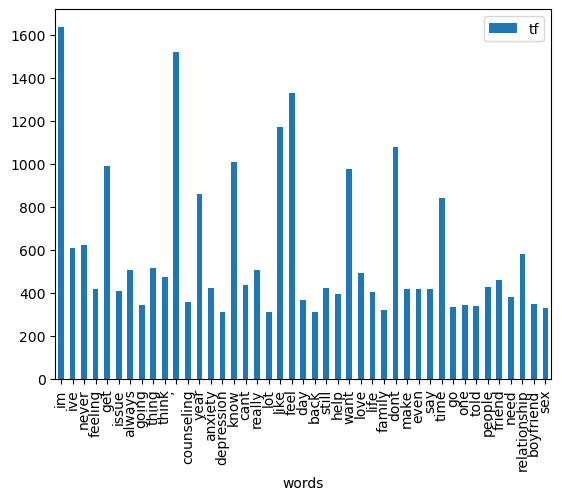

In [19]:
# Barplot for Context

tf_Context[tf_Context["tf"] > 300].plot.bar(x="words", y="tf")
plt.show()

# Emotions Anaylsis

In [21]:
!pip install transformers

from transformers import pipeline

In [22]:
from tqdm import tqdm
from transformers import pipeline

# Ensure tqdm displays progress in notebooks
tqdm.pandas()

# Extract and clean 'Context' column
contexts = data['Context']

# Load pre-trained emotion detection model
emotion_model = pipeline('sentiment-analysis', model='j-hartmann/emotion-english-distilroberta-base')

# Analyze emotions in 'Context' with progress tracking
print("Analyzing emotions in text...")
emotions = contexts.progress_apply(lambda x: emotion_model(x)[0]['label'])

# Add detected emotions as a new column
data['Detected_Emotion'] = emotions

print("Emotion analysis completed!")


Device set to use mps:0


Analyzing emotions in text...


100%|███████████████████████████████████████| 3512/3512 [02:11<00:00, 26.69it/s]

Emotion analysis completed!


In [23]:
data.head()

,Context,Response,Detected_Emotion
0,im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone,"If everyone thinks you're worthless, then maybe you need to find new people to hang out with.Seriously, the social context in which a person lives is a big influence in self-esteem.Otherwise, you can go round and round trying to understand why you're not worthless, then go back to the same crowd and be knocked down again.There are many inspirational messages you can find in social media. Maybe read some of the ones which state that no person is worthless, and that everyone has a good purpose to their life.Also, since our culture is so saturated with the belief that if someone doesn't feel good about themselves that this is somehow terrible.Bad feelings are part of living. They are the motivation to remove ourselves from situations and relationships which do us more harm than good.Bad feelings do feel terrible. Your feeling of worthlessness may be good in the sense of motivating you to find out that you are much better than your feelings today.",sadness
1,im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone,"Hello, and thank you for your question and seeking advice on this. Feelings of worthlessness is unfortunately common. In fact, most people, if not all, have felt this to some degree at some point in their life. You are not alone. Changing our feelings is like changing our thoughts - it's hard to do. Our minds are so amazing that the minute you change your thought another one can be right there to take it's place. Without your permission, another thought can just pop in there. The new thought may feel worse than the last one! My guess is that you have tried several things to improve this on your own even before reaching out on here. People often try thinking positive thoughts, debating with their thoughts, or simply telling themselves that they need to ""snap out of it"" - which is also a thought that carries some self-criticism. Some people try a different approach, and there are counselors out there that can help you with this. The idea is that instead of trying to change the thoughts, you change how you respond to them. You learn skills that allow you to manage difficult thoughts and feelings differently so they don't have the same impact on you that they do right now. For some people, they actually DO begin to experience less hurtful thoughts once they learn how to manage the ones they have differently. Acceptance and Commitment Therapy may be a good choice for you. There is information online and even self-help books that you can use to teach you the skills that I mentioned. Because they are skills, they require practice, but many people have found great relief and an enriched life by learning them. As for suicidal thoughts, I am very glad to read that this has not happened to you. Still, you should watch out for this because it can be a sign of a worsening depression. If you begin to think about this, it is important to reach out to a support system right away. The National Suicide Prevention Lifeline is 1-800-273-8255. The text line is #741741. I hope some other colleagues will provide you more suggestions. Be well...Robin Landwehr, DBH, LPCC",sadness
2,im going thing feeling barely sleep nothing think im worthless shouldnt ive never tried contemplated suicide ive always wanted fix issue never get around change feeling worthless everyone,First thing I'd suggest is getting the sleep you need or it will impact how you think and feel. I'd look at finding what is going well in your life and what you can be grateful for. I believe everyone has talents and wants to find their purpose in life. I think you can figure it out with some help.,sadness
3,im going thing feeling

In [24]:
data['Detected_Emotion'].value_counts()

Detected_Emotion
sadness     1338
fear         891
anger        539
neutral      321
joy          231
surprise     169
disgust       23
Name: count, dtype: int64

# Feature Extraction

In [26]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data
tfidf_matrix = vectorizer.fit_transform(contexts)

# Convert to array (if needed)
tfidf_array = tfidf_matrix.toarray()

# Model

## Data Spilting

In [29]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(tfidf_array, data['Detected_Emotion'], test_size=0.3, random_state=42)


In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
# Initialize the model
model = RandomForestClassifier()

## Fine Tuning

In [33]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters: {grid_search.best_params_}')


Best parameters: {'max_depth': None, 'n_estimators': 300}


# Train and Evaluation

## Train

In [36]:
model = RandomForestClassifier()
# Train the model
model.fit(X_train, y_train)

RandomForestClassifier()

## Evaluation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.9440227703984819
Classification Report:
              precision    recall  f1-score   support

       anger       0.99      0.93      0.96       162
     disgust       1.00      0.67      0.80         6
        fear       1.00      0.96      0.98       275
         joy       1.00      0.82      0.90        66
     neutral       0.93      0.94      0.94        85
     sadness       0.89      0.99      0.93       412
    surprise       1.00      0.77      0.87        48

    accuracy                           0.94      1054
   macro avg       0.97      0.87      0.91      1054
weighted avg       0.95      0.94      0.94      1054

Confusion Matrix:
[[151   0   0   0   1  10   0]
 [  0   4   0   0   0   2   0]
 [  0   0 263   0   1  11   0]
 [  0   0   0  54   0  12   0]
 [  0   0   0   0  80   5   0]
 [  2   0   0   0   4 406   0]
 [  0   0   0   0   0  11  37]]


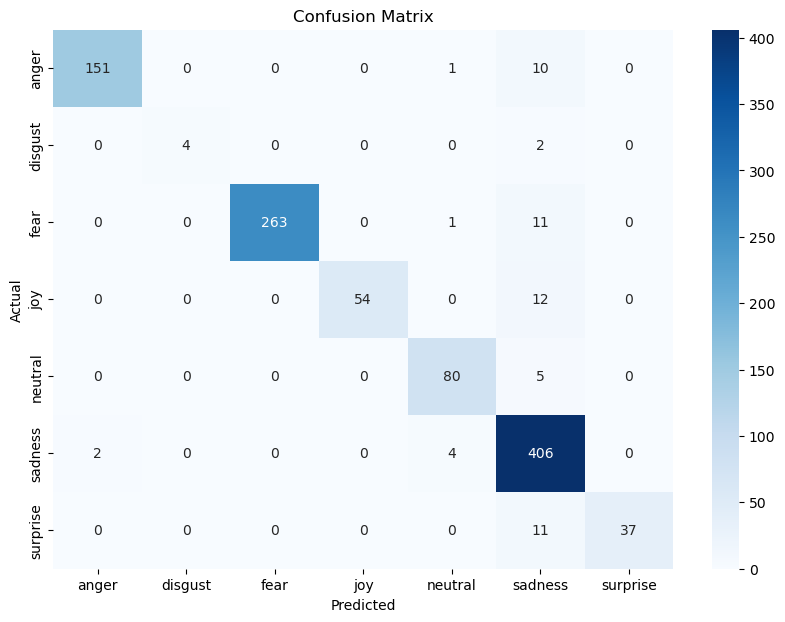

In [38]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Test Unseen Data

In [40]:
# Example new text
new_text = ["let's leave i am scared"]

# Clean and transform the new text
new_text_cleaned = [clean_text(text) for text in new_text]
new_text_tfidf = vectorizer.transform(new_text_cleaned)

# Predict emotion
predicted_emotion = model.predict(new_text_tfidf)
print(predicted_emotion)


['fear']


In [41]:

import torch
import numpy as np

# Function to analyze emotion intensity
def get_emotion_intensity(predictions):
    intensity_levels = ['low', 'medium', 'high']
    
    # Convert logits to probabilities using softmax
    probabilities = torch.nn.functional.softmax(torch.tensor(predictions), dim=0).numpy()
    max_prob = np.max(probabilities)
    
    # Define thresholds for intensity levels
    if max_prob < 0.5:
        intensity = 'low'
    elif max_prob < 0.75:
        intensity = 'medium'
    else:
        intensity = 'high'
    
    return intensity, max_prob

# Sample usage
sample_predictions = [2.1, 0.5, -1.3, 3.2, 1.7]  # Example model output logits
intensity, prob = get_emotion_intensity(sample_predictions)
print(f"Emotion Intensity: {intensity} (Confidence: {prob:.2f})")


Emotion Intensity: medium (Confidence: 0.61)


In [42]:

# Define chatbot responses based on emotion and intensity

emotion_responses = {
    'joy': {
        'low': "That's great! Keep enjoying the little things in life.",
        'medium': "Awesome! Sounds like you're having a good time.",
        'high': "Wow! That's fantastic! Keep spreading your happiness!"
    },
    'sadness': {
        'low': "I'm here if you need to talk.",
        'medium': "I'm sorry you're feeling this way. Do you want to share more?",
        'high': "I'm really sorry. You're not alone. It might help to reach out to someone you trust."
    },
    'anger': {
        'low': "I see you're a little frustrated. Want to talk about it?",
        'medium': "That sounds upsetting. I can listen if you need to vent.",
        'high': "It sounds like you're really upset. Maybe taking deep breaths could help."
    },
    'fear': {
        'low': "It's okay to feel nervous. What's on your mind?",
        'medium': "That sounds concerning. Would you like to talk through it?",
        'high': "I understand that you're really scared. Try grounding yourself in the present moment."
    },
    'neutral': {
        'low': "Got it! Anything else on your mind?",
        'medium': "Okay! I'm here if you need to chat.",
        'high': "Alright! Let me know if there's anything I can help with."
    }
}

# Function to generate chatbot response
def generate_chatbot_response(emotion, intensity):
    return emotion_responses.get(emotion, {}).get(intensity, "I'm here to chat!")

# Example usage
emotion = 'sadness'
intensity = 'high'
response = generate_chatbot_response(emotion, intensity)
print(f"Chatbot: {response}")


Chatbot: I'm really sorry. You're not alone. It might help to reach out to someone you trust.
